<a href="https://colab.research.google.com/github/ZijianDu/Awesome-Deblurring/blob/master/Iphone_defect_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Defect Classification/Detection for Iphone housing
# Author: Zijian Du

In [81]:
import pandas as pd
import numpy as np
# main ML framework
import sklearn
import matplotlib.pyplot as plt
import torch
import csv
from PIL import Image
import cv2
# mount drive for data
from google.colab import drive
drive.mount('/content/drive/')

SyntaxError: ignored

## Image preprocessing: convert image to gray scale, normalize image by moving image mean grayvalue to 128 then map back to 0-255 range

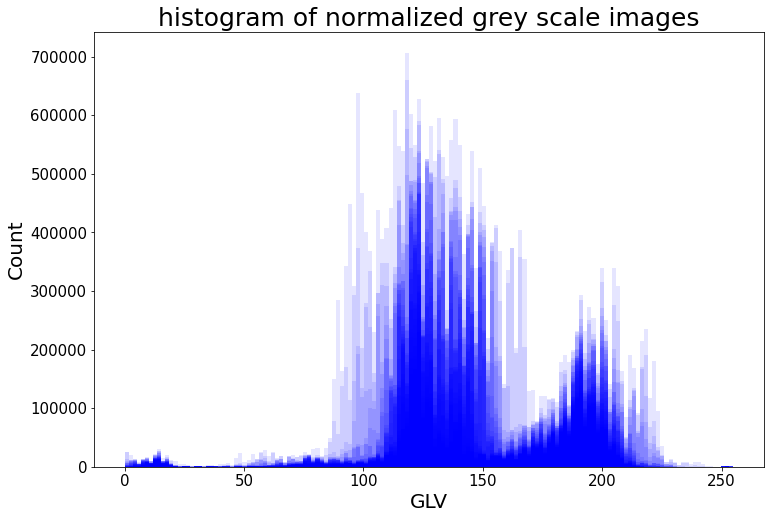

In [119]:
import glob, os
data_folder = "/content/drive/MyDrive/Colab Notebooks/CV_HW/images set/"
normalized_folder = "/content/drive/MyDrive/Colab Notebooks/CV_HW/normalized_imageset/"

ft = 20
plt.figure(figsize = (12, 8))
plt.xlabel('GLV', fontsize = ft)
plt.xticks(fontsize = ft - 5)
plt.yticks(fontsize = ft - 5)
plt.ylabel('Count', fontsize = ft)
plt.title('histogram of normalized grey scale images', fontsize = ft + 5)
for infile in glob.glob(data_folder + "*.jpg"):
    with Image.open(infile) as im:
      img = Image.open(infile).convert('L')
      image_arr = np.array(img)
      flattened = image_arr.flatten()
      image_normalized = np.zeros(shape = image_arr.shape)
      cv2.normalize(image_arr - np.mean(flattened) + 128, image_normalized, 0, 255, cv2.NORM_MINMAX)
      plt.hist(image_normalized.flatten(), bins = 150, alpha = 0.1, color = 'blue')
      Image.fromarray(image_normalized).convert("L").save(normalized_folder + infile[-6:-4]+".bmp")


## identify feature points for iphone cases

In [117]:
template = Image.open(normalized_folder + '06.bmp')
template_arr = np.array(template)
print(template_arr)


[[192 193 194 ... 171 168 168]
 [193 193 194 ... 170 168 168]
 [193 193 193 ... 169 168 168]
 ...
 [194 197 199 ... 182 183 183]
 [194 198 200 ... 181 184 184]
 [197 197 198 ... 182 183 184]]


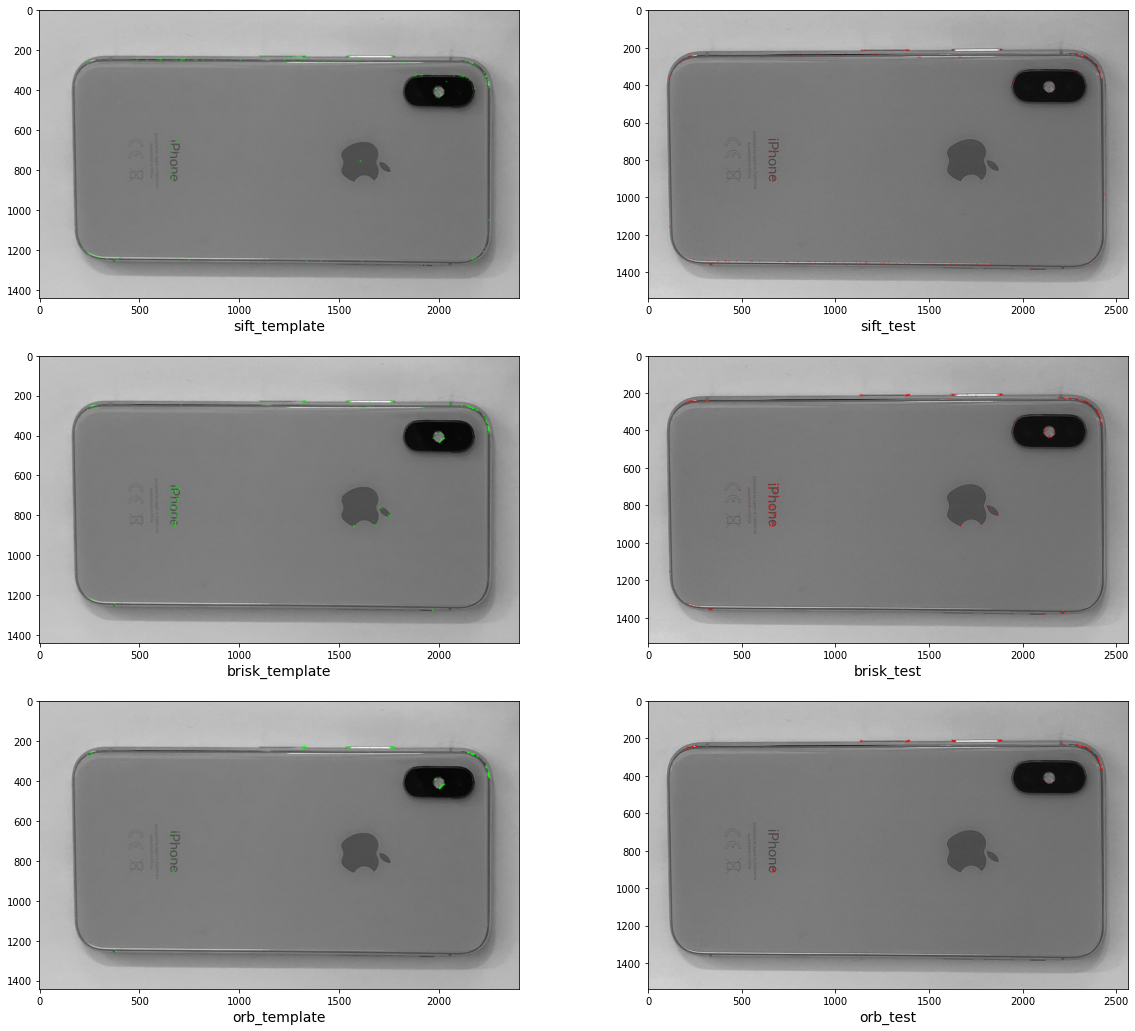

In [168]:
import timeit
template = cv2.imread(normalized_folder + '06.bmp')
test = cv2.imread(normalized_folder + '20.bmp')

def detectAndDescribe(image, method=None):    
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create(nfeatures = 200)
    elif method == 'brisk':
        descriptor = cv2.BRISK_create(thresh= 30)
    elif method == 'orb':
        descriptor = cv2.ORB_create(nfeatures = 200)

        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

methods = ['sift', 'brisk', 'orb']
allFeatures_temp, allKps_temp = {}, {}
allFeatures_test, allKps_test = {}, {}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,18), constrained_layout=False)
for idx, method in enumerate(methods):

  kpts_temp, features_temp = detectAndDescribe(template, method=method)
  kpts_test, features_test = detectAndDescribe(test, method = method)
  allFeatures_temp[method] = features_temp
  allFeatures_test[method] = features_test
  allKps_temp[method] = kpts_temp
  allKps_test[method] = kpts_test

  axes[idx,0].imshow(cv2.drawKeypoints(template, kpts_temp, None, color=(0,255,0)))
  axes[idx,0].set_xlabel(method + '_template', fontsize=14)
  axes[idx,1].imshow(cv2.drawKeypoints(test, kpts_test, None, color=(255,0,0)))
  axes[idx,1].set_xlabel(method + '_test', fontsize=14)


## create matching points


### functions to conduct actual feature matching

In [167]:
# create feature matching functions
def createMatcher(method, crossCheck):
  if method == 'sift':
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = crossCheck)
  elif method == 'brisk' or method == 'orb':
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = crossCheck)
  return bf

# create matching features and sort in order of strength
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
    # generate best match for two sets of features
    best_matches = bf.match(featuresA,featuresB)
    # sort the feature points in distince, with points with small distance has more similarity and are ordered first
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    return rawMatches

# create matching features with pre specified number of pairs 
def matchKeyPointsKNN(featuresA, featuresB, ratio, method, K):
  bf = createMatcher(method, crossCheck = False)
  allMatches = bf.knnMatch(featuresA, featuresB, K)
  matches = []

  # select distance within certain ratio of each other
  for m, n in allMatches:
    if m.distance < n.distance * ratio:
      matches.append(m)
  return matches
    


### conduct matching and visualize

In [ ]:
fig = plt.figure(figsize = (20, 8))
matches = matchKeyPointsBF(allFeatures_temp[methods[2]], allFeatures_test[methods[2]], method = 'orb')
image3 = cv2.drawMatches(template)
